In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
import re
from nltk.corpus import wordnet as wn 
import requests

In [174]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

データの数

In [175]:
s = 100

In [176]:
abstracts = []
cats=[]
qs = ['cs.AI', 'math.AC', 'astro-ph.CO','q-bio.BM','q-fin.CP']

for i in range(len(qs)):
  # APIエンドポイントとパラメータ
  url = "http://export.arxiv.org/api/query"
  params = {
      "search_query": "cat:" + qs[i],  # 検索クエリ。
      "start": 0,  # 取得開始位置
      "max_results": s,  # 取得する論文の数
  }
  category = [qs[i]] * s
  cats =cats + category

  # APIリクエストを送信
  response = requests.get(url, params=params)

  # レスポンスを解析してアブストラクトを取得
  data = response.text

  # XML形式のレスポンスを処理
  from xml.etree import ElementTree as ET

  root = ET.fromstring(data)
  namespace = {"arxiv": "http://www.w3.org/2005/Atom"}

  for entry in root.findall("arxiv:entry", namespace):
      title = entry.find("arxiv:title", namespace).text.strip()
      abstract = entry.find("arxiv:summary", namespace).text.strip()
      
      abstracts.append(abstract)

# 結果の表示
print("取得したアブストラクト:")
for abstract in abstracts:
    print(abstract)


取得したアブストラクト:
Because of their occasional need to return to shallow points in a search
tree, existing backtracking methods can sometimes erase meaningful progress
toward solving a search problem. In this paper, we present a method by which
backtrack points can be moved deeper in the search space, thereby avoiding this
difficulty. The technique developed is a variant of dependency-directed
backtracking that uses only polynomial space while still providing useful
control information and retaining the completeness guarantees provided by
earlier approaches.
Market price systems constitute a well-understood class of mechanisms that
under certain conditions provide effective decentralization of decision making
with minimal communication overhead. In a market-oriented programming approach
to distributed problem solving, we derive the activities and resource
allocations for a set of computational agents by computing the competitive
equilibrium of an artificial economy. WALRAS provides basic con

In [177]:
len(abstracts)

500

In [178]:
en_stop = nltk.corpus.stopwords.words('english')


In [179]:

en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         +["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         +["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         +en_stop
     

In [180]:
def remove_stopwords(word, stopwordset):
  if word in stopwordset:
    return None
  else:
    return word

In [181]:
def preprocessing_text(text):
  def cleaning_text(text):
    # @の削除
    pattern1 = '@|%'
    text = re.sub(pattern1, '', text)    
    pattern2 = '(|)'
    text = re.sub(pattern2, '', text)    
    pattern3 = '"'
    text = re.sub(pattern3, '', text)    
    pattern4 = '[0-9]'
    text = re.sub(pattern4, '', text)
    return text
  
  def tokenize_text(text):
    text = re.sub('[.,]', '', text)
    return text.split()

  def lemmatize_word(word):
    # make words lower  example: Python =>python
    word=word.lower()
    
    # lemmatize  example: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
      return lemma
    
  text = cleaning_text(text)
  tokens = tokenize_text(text)
  tokens = [lemmatize_word(word) for word in tokens]
  tokens = [remove_stopwords(word, en_stop) for word in tokens]
  tokens = [word for word in tokens if word is not None]
  return tokens
  
pp_docs = [preprocessing_text(text) for text in abstracts]
print(pp_docs[0])

['occasional', 'need', 'return', 'shallow', 'point', 'search', 'tree', 'exist', 'backtrack', 'method', 'sometimes', 'erase', 'meaningful', 'progress', 'toward', 'solving', 'search', 'problem', 'paper', 'present', 'method', 'backtrack', 'point', 'move', 'deep', 'search', 'space', 'thereby', 'avoid', 'difficulty', 'technique', 'develop', 'variant', 'dependency-directed', 'backtrack', 'use', 'polynomial', 'space', 'still', 'provide', 'useful', 'control', 'information', 'retain', 'completeness', 'guarantee', 'provide', 'earlier', 'approach']


In [182]:
pre_docs=[" ".join(doc) for doc in pp_docs]
print(pre_docs[0])

# vectorizer = TfidfVectorizer(max_features=200, token_pattern=u'(?u)\b\w+\b' )
vectorizer = TfidfVectorizer()


occasional need return shallow point search tree exist backtrack method sometimes erase meaningful progress toward solving search problem paper present method backtrack point move deep search space thereby avoid difficulty technique develop variant dependency-directed backtrack use polynomial space still provide useful control information retain completeness guarantee provide earlier approach


In [183]:
tf_idf = vectorizer.fit_transform(pre_docs)


***太字***

In [184]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

pca =TruncatedSVD(n_components=3)
X_transformed = pca.fit_transform(tf_idf)

In [185]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state = 0)


In [186]:
km.fit(tf_idf)
labels = km.labels_ 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [187]:

for doc, cls, cat in zip(pre_docs, labels, cats):
    print(cls,cat,doc)

4 cs.AI occasional need return shallow point search tree exist backtrack method sometimes erase meaningful progress toward solving search problem paper present method backtrack point move deep search space thereby avoid difficulty technique develop variant dependency-directed backtrack use polynomial space still provide useful control information retain completeness guarantee provide earlier approach
4 cs.AI market system constitute well-understood class mechanism certain conditions provide effective decentralization decision making minimal communication overhead market-oriented programming approach distribute problem solving derive activity resource allocation set computational agent computing competitive equilibrium artificial economy walras provide basic construct defining computational market structure protocol deriving correspond equilibrium particular realization approach form multicommodity flow problem see careful construction decision process accord economic principle lead eff

In [188]:
from collections import Counter
# 配列を5つに分割
sub_arrays = np.array_split(labels, 5)

# 各部分配列の中で最頻値を求める
most_common_values_rate = []
for sub_array in sub_arrays:
    counter = Counter(sub_array)
    most_common_value = counter.most_common(1)[0][0]
    c =0 
    print(most_common_value)
    for i in sub_array :
      if(i == most_common_value):
        c = c + 1
    c = c/s
    most_common_values_rate.append(c)

# 結果の表示
print(most_common_values_rate)

4
0
2
3
1
[1.0, 0.97, 0.98, 0.6, 0.6]


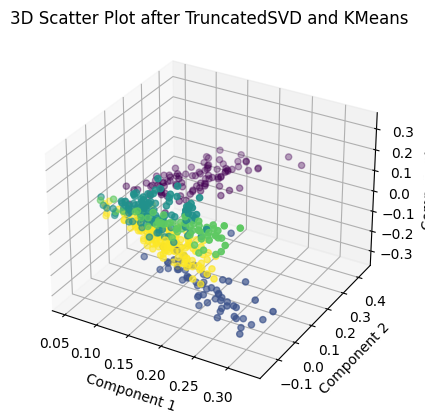

In [189]:
# 3次元プロットの作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], c=labels)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


plt.title("3D Scatter Plot after TruncatedSVD and KMeans")
plt.show()


In [190]:
import plotly.graph_objects as go

color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'purple'}

# 3D散布図の作成
fig = go.Figure(data=[go.Scatter3d(x=X_transformed[:, 0], y=X_transformed[:, 1], z=X_transformed[:, 2], mode='markers',  marker=dict(
    color=[color_map[label] for label in labels],
    size=1
))])

# レイアウトの設定
fig.update_layout(scene=dict(
    xaxis_title='X軸',
    yaxis_title='Y軸',
    zaxis_title='Z軸'
))

# プロットの表示
fig.show()